In [76]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PowerTransformer, PolynomialFeatures, KBinsDiscretizer, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import VarianceThreshold

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer

In [41]:
df = pd.read_csv("WELFake_Dataset.csv")

In [42]:
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [43]:
df.describe()

,Unnamed: 0,label
count,72134.000000,72134.000000
mean,36066.500000,0.514404
std,20823.436496,0.499796
min,0.000000,0.000000
25%,18033.250000,0.000000
50%,36066.500000,1.000000
75%,54099.750000,1.000000
max,72133.000000,1.000000


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [45]:
df.isnull().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

In [46]:
df = df.fillna('')

In [47]:
df.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [48]:
print(df['label'].value_counts())

label
1    37106
0    35028
Name: count, dtype: int64


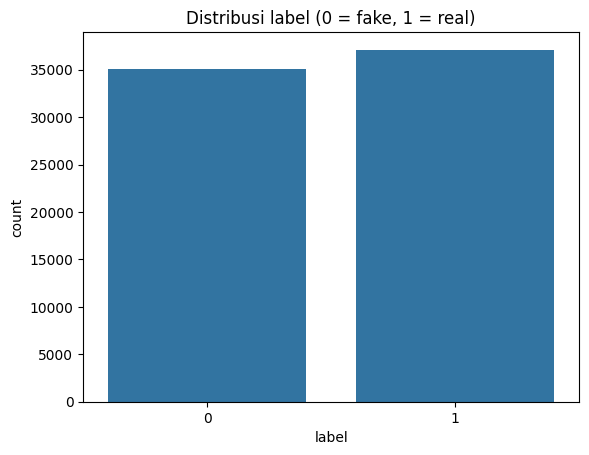

In [49]:
sns.countplot(x='label', data=df)
plt.title("Distribusi label (0 = fake, 1 = real)")
plt.show()

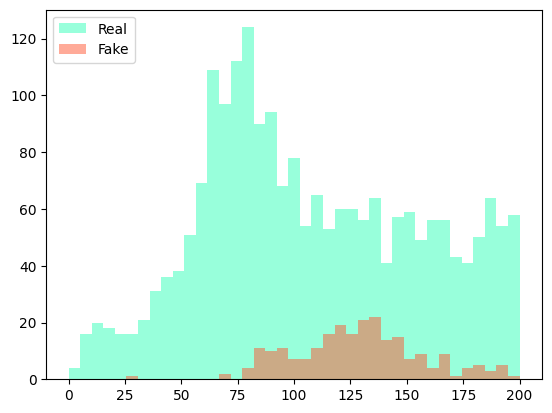

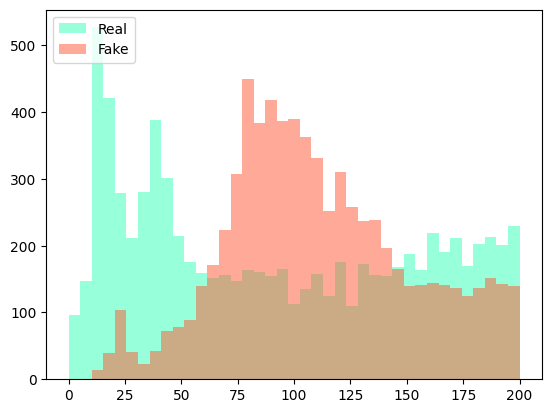

In [53]:
df["title_text"] = df["title"] + df["text"]
df['text_len'] = df["title_text"].apply(lambda x: len(x) - x.count(" "))
df['word_count'] = df["title_text"].apply(lambda x: len(str(x).split(" ")))
bins = np.linspace(0, 200, 40)
plt.hist(df[df["label"]== 1]["text_len"], bins, alpha=0.5, label="Real", color="#33FFB8")
plt.hist(df[df["label"]== 0]["text_len"], bins, alpha=0.5, label="Fake", color="#FF5733")
plt.legend(loc="upper left")
plt.show()
plt.hist(df[df["label"]== 1]["word_count"], bins, alpha=0.5, label="Real", color="#33FFB8")
plt.hist(df[df["label"]== 0]["word_count"], bins, alpha=0.5, label="Fake", color="#FF5733")
plt.legend(loc="upper left")
plt.show()

# Title

## Wordcloud

In [70]:
y_title = df['label']
X_train_title, X_test_title, y_train_title, y_test_title = train_test_split(df['title'], y_title, test_size=0.2, random_state=53)

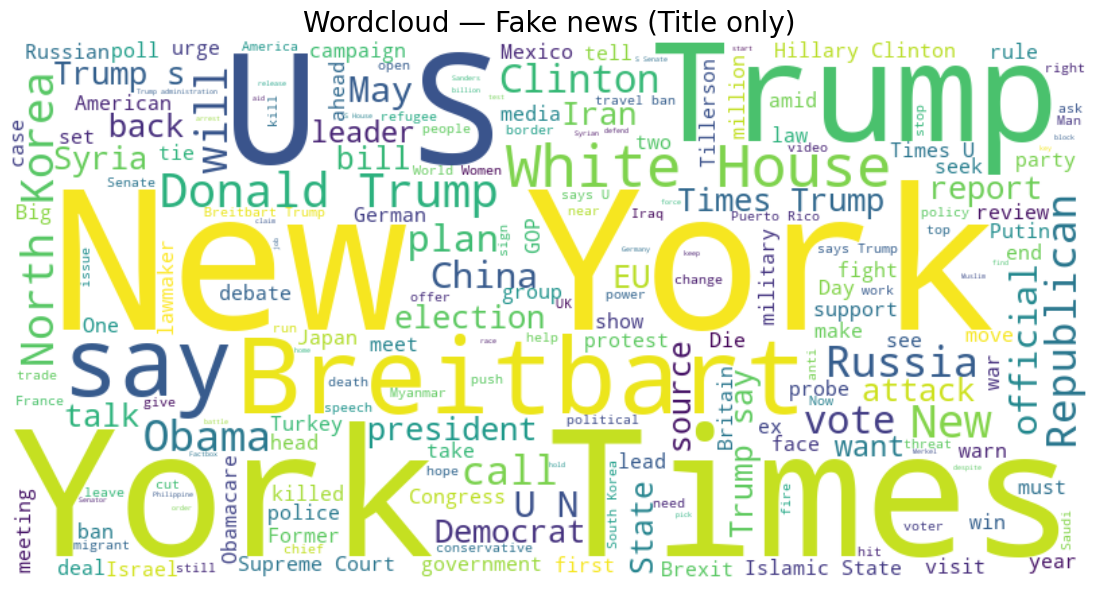

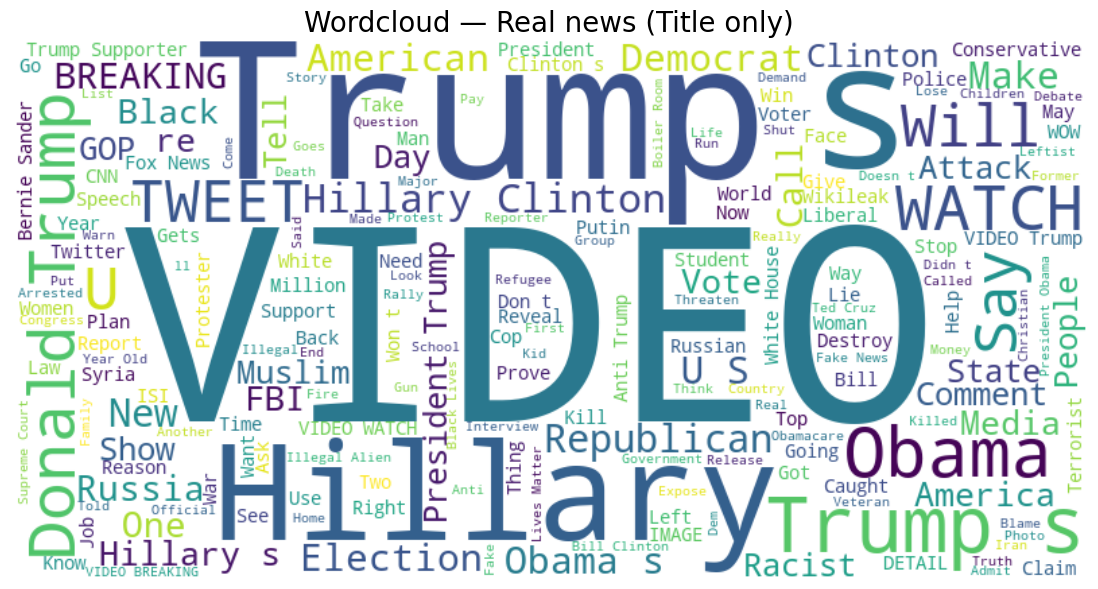

In [71]:
for label, name in [(0, "Fake"), (1, "Real")]:
    text = " ".join(str(txt) for txt in X_train_title[y_train_title==label])
    wc = WordCloud(stopwords=STOPWORDS,
                   width=800, height=400,
                   background_color='white').generate(text)
    plt.figure(figsize=(15,7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f"Wordcloud — {name} news (Title only)", fontsize=20)
    plt.axis('off')
    plt.show()

## TF-IDF Title

In [ ]:
tfidf_title = TfidfVectorizer(
    stop_words='english',
    max_features=5000,     
    ngram_range=(1,2)      
)

tfidf_train_title = tfidf_title.fit_transform(X_train_title)
tfidf_test_title = tfidf_title.transform(X_test_title)

In [ ]:
Logistic = LogisticRegression(max_iter=200)
Logistic.fit(tfidf_train_title, y_train_title)
    
y_pred = Logistic.predict(tfidf_test_title)

print("Accuracy:", accuracy_score(y_test_title, y_pred))

Accuracy: 0.8966521106259098


In [ ]:
nb = MultinomialNB()
nb.fit(tfidf_train_title, y_train_title)
    
y_pred_nb = nb.predict(tfidf_test_title)
print("Naive Bayes Accuracy:", accuracy_score(y_test_title, y_pred_nb))

In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf.fit(tfidf_train_title, y_train_title)

y_pred_rf = rf.predict(tfidf_test_title)
print("Random Forest Accuracy:", accuracy_score(y_test_title, y_pred_rf))

In [ ]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(tfidf_train_title, y_train_title)

y_pred_xgb = xgb.predict(tfidf_test_title)
print("XGBoost Accuracy:", accuracy_score(y_test_title, y_pred_xgb))

In [ ]:
voting = VotingClassifier(
    estimators=[
        ('logistic', Logistic),
        ('nb', nb),
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'     
)

voting.fit(tfidf_train_title, y_train_title)

y_pred_vote = voting.predict(tfidf_test_title)
print("Soft Voting Accuracy:", accuracy_score(y_test_title, y_pred_vote))

## BERT Title

# Title + Text

## Wordcloud

In [78]:
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(df['title_text'], y, test_size=0.2, random_state=53)

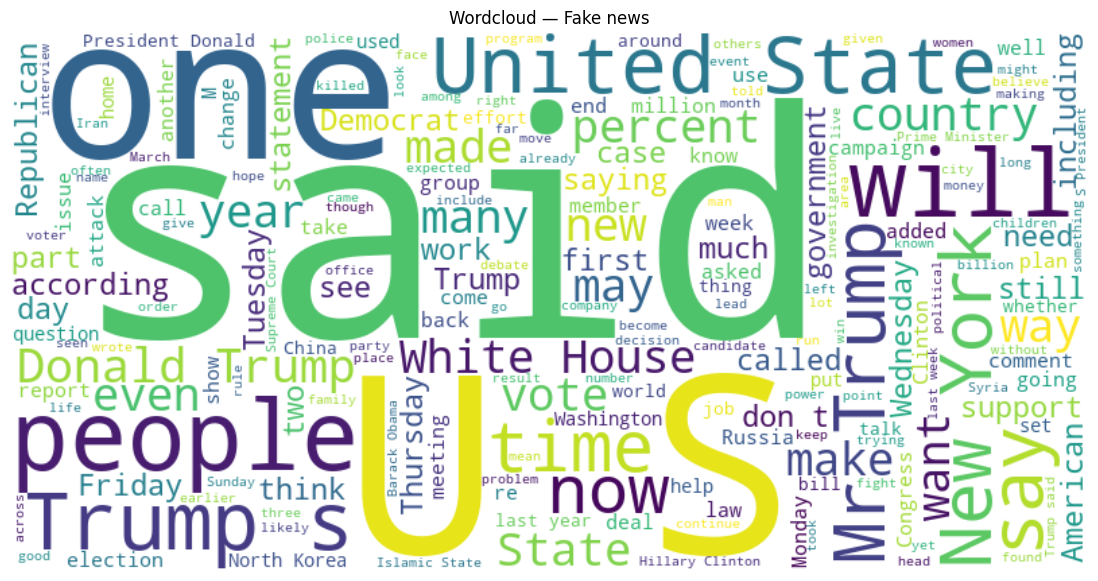

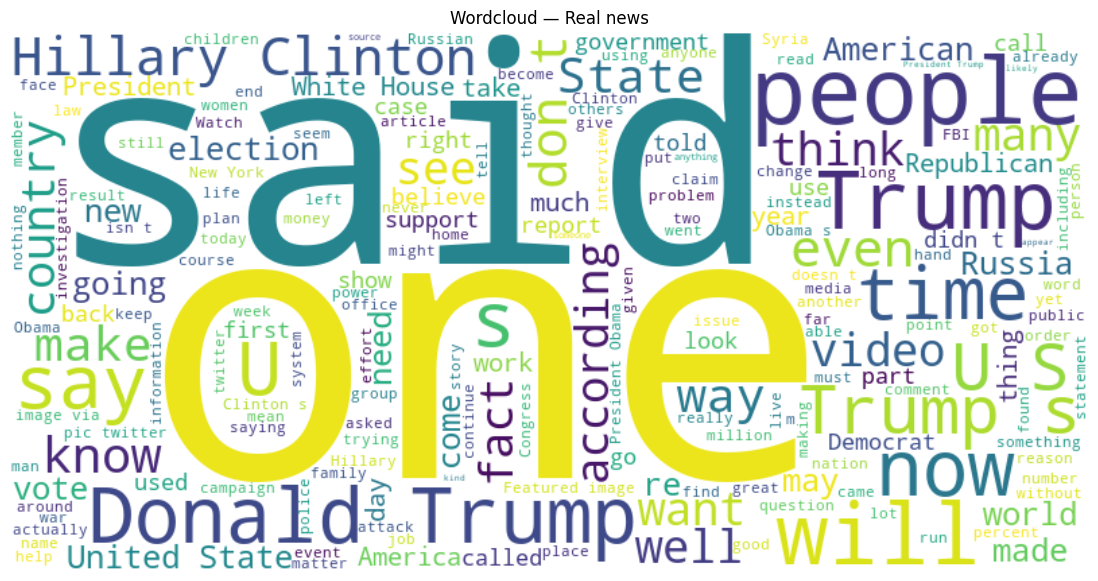

In [ ]:
for label, name in [(0, "Fake"), (1, "Real")]:
    text = " ".join(str(txt) for txt in X_train[y_train==label])
    wc = WordCloud(stopwords=STOPWORDS,
                   width=800, height=400,
                   background_color='white').generate(text)
    plt.figure(figsize=(15,7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f"Wordcloud — {name} news (Title + Text)", fontsize=20)
    plt.axis('off')
    plt.show()

## TF-IDF Title + Text

In [79]:
tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=5000,     
    ngram_range=(1,2)      
)

tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)

In [80]:
Logistic = LogisticRegression(max_iter=200)
Logistic.fit(tfidf_train, y_train)
    
y_pred_logistic = Logistic.predict(tfidf_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logistic))

Logistic Regression Accuracy: 0.9422610383309074


In [81]:
nb = MultinomialNB()
nb.fit(tfidf_train, y_train)

y_pred_nb = nb.predict(tfidf_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.8502114091633742


In [82]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf.fit(tfidf_train, y_train)

y_pred_rf = rf.predict(tfidf_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy: 0.9552921605323352


In [83]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(tfidf_train, y_train)

y_pred_xgb = xgb.predict(tfidf_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))

XGBoost Accuracy: 0.9548069591737715


In [84]:
voting = VotingClassifier(
    estimators=[
        ('logistic', Logistic),
        ('nb', nb),
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'     
)

voting.fit(tfidf_train, y_train)

y_pred_vote = voting.predict(tfidf_test)
print("Soft Voting Accuracy:", accuracy_score(y_test, y_pred_vote))

Soft Voting Accuracy: 0.9518264365425938


## BERT Title + Text